In [58]:
help(pl.fit_transform_plot)

Help on method fit_transform_plot in module gtda.base:

fit_transform_plot(X, y=None, sample=0, **plot_params) method of gtda.diagrams.representations.PersistenceLandscape instance
    Fit to data, then apply :meth:`transform_plot`.
    
    Parameters
    ----------
    X : ndarray of shape (n_samples, ...)
        Input data.
    
    y : ndarray of shape (n_samples,) or None
        Target values for supervised problems.
    
    sample : int
        Sample to be plotted.
    
    **plot_params
        Optional plotting parameters.
    
    Returns
    -------
    Xt : ndarray of shape (1, ...)
        Transformed one-sample slice from the input.



In [59]:
from persim import PersistenceImager
help(PersistenceImager)

Help on class PersistenceImager in module persim.images:

class PersistenceImager(sklearn.base.TransformerMixin)
 |  PersistenceImager(birth_range=None, pers_range=None, pixel_size=None, weight=None, weight_params=None, kernel=None, kernel_params=None)
 |  
 |  Transformer which converts persistence diagrams into persistence images.
 |  
 |  Parameters
 |  ----------
 |  birth_range : pair of floats
 |      Range of persistence pair birth values covered by the persistence image (default: (0.0, 1.0)).
 |  pers_range : pair of floats
 |      Range of persistence pair persistence (death-birth) values covered by the persistence image (default: (0.0, 1.0)).
 |  pixel_size : float
 |      Dimensions of each square pixel (default: 0.2).
 |  weight : callable or str in ['persistence', 'linear_ramp']
 |      Function which weights the birth-persistence plane (default: 'persistence').
 |  weight_params : dict
 |      Arguments needed to specify the weight function (default: {'n': 1.0}).
 |  kern

          mean  std
cluster            
0.0      100.0  0.0
1.0      100.0  0.0
           label   cluster  coherence
mean  126.500000  0.250000      100.0
std    72.890329  0.433874        0.0


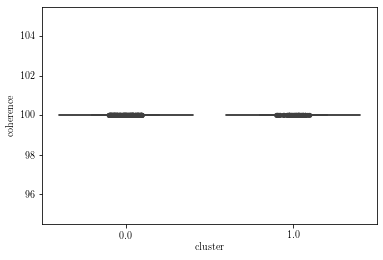

In [77]:


    for i in range(1,253):

        # Check whether we are dealing with a proper subject, or an
        # information key in the data.
        #try:
        #    _ = int(subject)
        #except ValueError:
        #    continue
         
        pairs = list(itertools.chain.from_iterable(persistence_diagrams[i-1:i,:,:-1]))

        clf = PersistenceImager()
        img = clf.transform(pairs)
        
        coherence_values = []
        for j in range(252):
            
            X = np.array(img)
            nn = NearestNeighbors(n_neighbors=3)
            nn.fit(X)

            all_neighbours = nn.kneighbors(
            X, n_neighbors=3, return_distance=False
         )

            n_incoherent_points = 0

            for index, neighbours in enumerate(all_neighbours):
                is_incoherent = (neighbours > index + i).sum() \
                          + (neighbours < index - i).sum()

                is_incoherent /= 3

                n_incoherent_points += is_incoherent

            coherence_values.append(100 - n_incoherent_points / len(X) * 100)

    df = pd.read_csv('participant_groups.csv')
    df.label=df.label+1
    df['coherence'] = coherence_values

    print(df.groupby('cluster')['coherence'].agg(['mean', 'std']))

    print(df[df['cluster'] != 5].agg(['mean', 'std']))

    ax = sns.boxplot(x='cluster', y='coherence', data=df)
    ax = sns.stripplot(
            x='cluster', y='coherence',
            data=df,
            ax=ax,
            color='.25'
        )

    plt.show()

In [79]:
#
# Cluster persistence images of participants and stores the linkage
# matrix and the distance matrix.
import argparse
import collections
import glob
import json
import os

import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

from tqdm import tqdm


def get_linkage_matrix(model, **kwargs):
    """Calculate linkage matrix and return it."""
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    return linkage_matrix

X = []

for i in range(1,253):
    # Store a mean representation of the persistence image of each
    # participant. This is not necessarily the smartest choice but
    # a very simple one.
    pairs = list(itertools.chain.from_iterable(persistence_diagrams[i-1:i,:,:-1]))

    clf = PersImage(pixels=(100,100))
    images = clf.transform(pairs)
        
    x = np.mean(images, axis=0).ravel()

    X.append(x)

X = np.array(X)
D = pairwise_distances(X)

# Use subject labels as 'true' labels (even though we have no way of
# telling in a clustering setup)
#y = list(sorted(subject))
y = list(subject)

clf = AgglomerativeClustering(
    distance_threshold=0,      # compute full dendrogram
    n_clusters=None,           # do not limit number of clusters
    affinity='precomputed',    # use our distances from above
    linkage='average',         # cannot use Ward linkage here
)
model = clf.fit(D)
M = get_linkage_matrix(model)

experiment = os.path.basename('test')
experiment = os.path.splitext(experiment)[0]

# FIXME: needs to be made configurable; this presumes that we are
# being called from another folder.
#os.chdir('../results/clusterings')

out_filename = f'Linkage_matrix_{experiment}.txt'

np.savetxt(out_filename, M)
np.savetxt('Labels.txt', y, fmt='%s')

# Also store the distance matrix. This makes it possible not only to
# completely reconstruct the clustering but also try out different
# settings for each algorithm later on.
out_filename = f'Distance_matrix_{experiment}.txt'

np.savetxt(out_filename, D)

# Get cluster assignments for simple binary clustering; this is the
# easiest clustering we can do here.
clf = AgglomerativeClustering(affinity='precomputed', linkage='average')
y_pred = clf.fit_predict(D).tolist()

assignments = {
    subject: label for (subject, label) in zip(y, y_pred)
}

output_filename = f'Assignments_{experiment}.json'

with open(output_filename, 'w') as f:
    json.dump(assignments, f, indent=4)

/Users/morilla/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning:

Call to deprecated class PersImage. (Replaced with the class `persim.PersistenceImager`.) -- Deprecated since version 0.1.5.



PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussi

PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussi

PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=None, specs=None, kernel_type="gaussi

In [80]:
help(PersImage)

Help on class PersImage in module persim.images:

class PersImage(sklearn.base.TransformerMixin)
 |  PersImage(*args, **kwargs)
 |  
 |  Initialize a persistence image generator.
 |  
 |  Parameters
 |  ----------
 |  
 |      pixels : pair of ints like (int, int)
 |          Tuple representing number of pixels in return image along x and y axis.
 |      spread : float
 |          Standard deviation of gaussian kernel.
 |      specs : dict
 |          Parameters for shape of image with respect to diagram domain. This is used if you would like images to have a particular range. Shaped like::
 |  
 |              {
 |                  "maxBD": float,
 |                  "minBD": float
 |              }
 |  
 |      kernel_type : string or ...
 |          TODO: Implement this feature.
 |          Determine which type of kernel used in the convolution, or pass in custom kernel. Currently only implements Gaussian.
 |      weighting_type : string or ...
 |          TODO: Implement this featu

In [81]:
# import itertools 
# from persim import PersImage --> already loaded up there!

images0 = []

for i in range(1,253):
    # Store a mean representation of the persistence image of each
    # participant. This is not necessarily the smartest choice but
    # a very simple one.
    pairs = list(itertools.chain.from_iterable(persistence_diagrams[i-1:i,:,:-1]))

    clf = PersImage(pixels=(100,100), spread=1.0)
    values = clf.transform(pairs)
    images0.append(values)

/Users/morilla/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning:

Call to deprecated class PersImage. (Replaced with the class `persim.PersistenceImager`.) -- Deprecated since version 0.1.5.



PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weigh

PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weigh

PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weigh

PersImage(pixels=(100, 100), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")


In [82]:
Mor = pd.read_excel('./Base de donnees greffe pulmonaire_Ian_Samy.xlsx', index_col=0)
Mor.columns = Mor.columns.str.replace(' ','_')

/Users/morilla/Python3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning:

Unknown extension is not supported and will be removed



In [95]:
#
# Visualises persistence-based embeddings in the form of trajectories
# in a space of a given dimension. This is a simplified version of the
# generic embedding script, focussing on the relevant scenarios for a
# publication. Moreover, only a single trajectory is calculated per
# cohort.

import argparse
import json
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from phate import PHATE


def embed(Z, name, rolling=None, joint_embedding=False):
    """Embedding function."""
    encoder = PHATE(
        n_components=2,
        mds_solver='smacof',
        random_state=42,
        n_pca=80,
    )

    # Will be filled with the lower-dimensional representations of each
    # cohort. This makes visualising everything easier.
    df = []

    # Will contain entropy numbers per cohort.
    entropy = []

    if joint_embedding:
        X = encoder.fit_transform(np.vstack(Z))
        df = pd.DataFrame(X, columns=['x', 'y'])
    else:
        for cohort in Z:

            if rolling is not None:
                cohort = pd.DataFrame(cohort).rolling(
                            rolling,
                            axis=0,
                            min_periods=1
                        ).mean()

            X = encoder.fit_transform(cohort)
            df.append(X)

            # Calculate von Neumann entropy for the selected value of
            # $t$. We take the last value of the selected sequence as
            # the value at $t$.
            t = encoder.optimal_t
            _, vne = encoder._von_neumann_entropy(t + 1)

            # Only keep the last entropy value, i.e. the one
            # corresponding to the *largest* $t$.
            vne = vne[-1]
            entropy.append(vne)

        df = np.concatenate(df)
        df = pd.DataFrame(df, columns=['x', 'y'])

    n = Z.shape[0]  # number of cohorts
    m = Z.shape[1]  # number of time steps

    df['cohort'] = np.array([[i] * m for i in range(n)]).ravel()
    df['time'] = np.array(list(np.arange(m)) * n).ravel()

    print(
        'Entropies for the individual cohorts:',
        ['{0:0.2f}'.format(e) for e in entropy]
    )

    # FIXME: make configurable
    #if args.drop:
    df['time'] += 3

    #df['séjour_réanimation'] = \
       # np.array(
        #    list(df_events['durée de séjour en réanimation (1er séjour)'].values) * n
        #)

    # Store data; this tries to be smart and create a proper filename
    # automatically.
    if rolling is not None:
        name += f'_r{rolling}'

    name += '.csv'

    os.makedirs('../cohort_trajectories', exist_ok=True)
    df.to_csv(os.path.join(
            '../cohort_trajectories', name
        ),
        index=False,
        na_rep='nan',
    )

    g = sns.FacetGrid(
            df,
            col='cohort',
            hue='time',
            palette='Spectral',
            sharex=False,
            sharey=False, 
            height=7,  # Increase height of plot grid
            aspect=1)  # Widen each individual plot)

    g = g.map(plt.scatter, 'x', 'y', s=100)

    #plt.show()
    plt.savefig('../cohort_trajectories/trajectories_ECMO_sigma1_r100_3t.pdf', dpi=300, bbox_inches='tight')

#os.chdir('../Alexy/risk_1y_5y_database/')

#for i in range(1,253):
  

    # Filter subjects; this could be solved smarter...
    #subjects = subject
    #subjects = [subject for subject in subjects if len(subject) == 3]

df_groups = pd.read_csv('participant_groups.csv')
df_groups.label=df_groups.label+1
df_events = pd.read_excel('annotations.xlsx')
df_events.index = df_events['NOM']
ECM2 = Mor[['ECMO_pré-opératoire','ECMO_peropératoire_','ECMO_en_Réanimation']]
ECM2['subject']= ECM2.index
table1 = ECM2.groupby(['ECMO_pré-opératoire','ECMO_peropératoire_','ECMO_en_Réanimation','subject']).size().reset_index().rename(columns={0:'count'})
table2 = ECM2.groupby(['ECMO_pré-opératoire','ECMO_peropératoire_','ECMO_en_Réanimation']).size().reset_index().rename(columns={0:'count'})

c0 = table1.subject[:73]
c1 = table1.subject[73:73+104]
c2 = table1.subject[73+104:73+104+59]
c3 = table1.subject[73+104+59:73+104+59+5]
c4 = table1.subject[73+104+59+5:73+104+59+5+16]

df_events['Sky color'][c0] = 'dark blue'
df_events['Sky color'][c1] = 'light orange'
df_events['Sky color'][c2] = 'deep orange, purple'
df_events['Sky color'][c3] = 'orange pink'
df_events['Sky color'][c4] = 'dark orange'
#, , 'blue',
 #      , , 'medium orange'


    #X = np.concatenate(
    #    [np.array([images[subject]]) for subject in subjects]
    #)
X = np.array(images0)

    # TODO: make extent of removal configurable
    #if args.drop:
X = X[:, 3:, :]
df_events = df_events[3:]

y = df_groups['cluster'].values
cohorts = sorted(set(y))

assert X.shape[0] == len(y)

    # Regardless of the operating mode, we need a mean representation of
    # each cohort. This reduces the dimension of our tensor from the no.
    # of participants to the number of cohorts.
Z = np.stack(
    [np.mean(X[y == cohort], axis=0) for cohort in cohorts],
)

assert Z.shape[0] == len(cohorts)

embed(
    Z,
    os.path.splitext(os.path.basename('trajectories_ECMO_sigma1.0'))[0],
    '100_3t',
    True 
)

AttributeError: module 'natsort' has no attribute 'compat'

Calculating PHATE...
  Running PHATE on 194 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.01 seconds.
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.03 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 0.03 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...


/Users/morilla/Python3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning:

Unknown extension is not supported and will be removed

/Users/morilla/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/morilla/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/morilla/Python3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a Da

  Calculated metric MDS in 0.08 seconds.
Calculated PHATE in 0.15 seconds.
Entropies for the individual cohorts: []


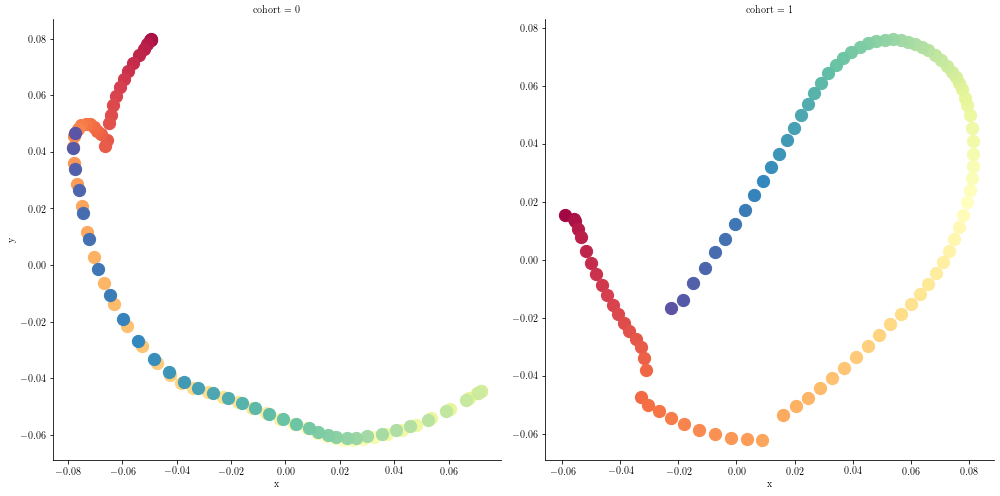

In [247]:
def embed(Z, name, rolling=None, joint_embedding=False):
    """Embedding function."""
    encoder = PHATE(
        n_components=2,
        mds_solver='smacof',
        random_state=42,
        n_pca=80,
    )

    # Will be filled with the lower-dimensional representations of each
    # cohort. This makes visualising everything easier.
    df = []

    # Will contain entropy numbers per cohort.
    entropy = []

    if joint_embedding:
        X = encoder.fit_transform(np.vstack(Z))
        df = pd.DataFrame(X, columns=['x', 'y'])
    else:
        for cohort in Z:

            if rolling is not None:
                cohort = pd.DataFrame(cohort).rolling(
                            rolling,
                            axis=0,
                            min_periods=1
                        ).mean()

            X = encoder.fit_transform(cohort)
            df.append(X)

            # Calculate von Neumann entropy for the selected value of
            # $t$. We take the last value of the selected sequence as
            # the value at $t$.
            t = encoder.optimal_t
            _, vne = encoder._von_neumann_entropy(t + 1)

            # Only keep the last entropy value, i.e. the one
            # corresponding to the *largest* $t$.
            vne = vne[-1]
            entropy.append(vne)

        df = np.concatenate(df)
        df = pd.DataFrame(df, columns=['x', 'y'])

    n = Z.shape[0]  # number of cohorts
    m = Z.shape[1]  # number of time steps

    df['cohort'] = np.array([[i] * m for i in range(n)]).ravel()
    df['time'] = np.array(list(np.arange(m)) * n).ravel()

    print(
        'Entropies for the individual cohorts:',
        ['{0:0.2f}'.format(e) for e in entropy]
    )

    # FIXME: make configurable
    #if args.drop:
    df['time'] += 3

    #df['séjour_réanimation'] = \
       # np.array(
        #    list(df_events['durée de séjour en réanimation (1er séjour)'].values) * n
        #)

    # Store data; this tries to be smart and create a proper filename
    # automatically.
    if rolling is not None:
        name += f'_r{rolling}'

    name += '.csv'

    os.makedirs('../cohort_trajectories', exist_ok=True)
    df.to_csv(os.path.join(
            '../cohort_trajectories', name
        ),
        index=False,
        na_rep='nan',
    )

    g = sns.FacetGrid(
            df,
            col='cohort',
            hue='time',
            palette='Spectral',
            sharex=False,
            sharey=False, 
            height=7,  # Increase height of plot grid
            aspect=1)  # Widen each individual plot)

    g = g.map(plt.scatter, 'x', 'y', s=150)

    #plt.show()
    plt.savefig('../cohort_trajectories/trajectories_insuffisance_rénale_aiguë_sigma1_r100_3t.pdf', dpi=300, bbox_inches='tight')

#os.chdir('../Alexy/risk_1y_5y_database/')

#for i in range(1,253):
  

    # Filter subjects; this could be solved smarter...
    #subjects = subject
    #subjects = [subject for subject in subjects if len(subject) == 3]

df_groups = pd.read_csv('participant_groups.csv')
df_groups.label=df_groups.label+1
df_events = pd.read_excel('annotations.xlsx')
df_events.index = df_events['NOM']
ECM2 = Mor[['insuffisance_rénale_aiguë']]
ECM2['subject']= ECM2.index
table1 = ECM2.groupby(['insuffisance_rénale_aiguë','subject']).size().reset_index().rename(columns={0:'count'})
table2 = ECM2.groupby(['insuffisance_rénale_aiguë']).size().reset_index().rename(columns={0:'count'})


c0 = table1.subject[:73]
c1 = table1.subject[73:73+104]
c2 = table1.subject[73+104:73+104+59]
c3 = table1.subject[73+104+59:73+104+59+5]
c4 = table1.subject[73+104+59+5:73+104+59+5+16]

df_events['Sky color'][c0] = 'dark blue'
df_events['Sky color'][c1] = 'light orange'
df_events['Sky color'][c2] = 'deep orange, purple'
df_events['Sky color'][c3] = 'orange pink'
df_events['Sky color'][c4] = 'dark orange'
#, , 'blue',
 #      , , 'medium orange'


    #X = np.concatenate(
    #    [np.array([images[subject]]) for subject in subjects]
    #)
X = np.array(images0)

    # TODO: make extent of removal configurable
    #if args.drop:
X = X[:, 3:, :]
df_events = df_events[3:]

y = df_groups['cluster'].values
cohorts = sorted(set(y))

assert X.shape[0] == len(y)

    # Regardless of the operating mode, we need a mean representation of
    # each cohort. This reduces the dimension of our tensor from the no.
    # of participants to the number of cohorts.
Z = np.stack(
    [np.mean(X[y == cohort], axis=0) for cohort in cohorts],
)

assert Z.shape[0] == len(cohorts)

embed(
    Z,
    os.path.splitext(os.path.basename('trajectories_insuffisance_rénale_aiguë_sigma1.0'))[0],
    '100_3t',
    True 
)


In [850]:
mask=ECM2["insuffisance_rénale_aiguë"]==1
np.where(mask)[0]

array([  9,  10,  17,  19,  20,  27,  30,  31,  37,  55,  60,  78,  81,
        99, 101, 103, 114, 129, 132, 143, 146, 161, 162, 164, 168, 171,
       174, 175, 190, 196, 212, 213, 222, 225, 236, 240, 245])

In [881]:
c0

0                  ABDAT
1                  AHMED
2                AIT ALI
3                ALAZARD
4                   ALIX
5              ALLAVOINE
6                 AMBERT
7                 AMIACH
8                AUGUSTO
9                 AUPIED
10               Abdalla
11                 BANCE
12              BANNOURI
13              BARATHON
14                BEATRE
15              BELINGER
16              BELLAHIM
17             BEN FARAH
18               BENADDA
19              BENSALEM
20               BENYETA
21              BLANCHON
22             BLANGILLE
23                BLIVET
24                 BODIN
25                BONDAZ
26               BOSSONE
27               BOUAZIS
28              BROGNARD
29          BROUSSOULOUX
30              Baptiste
31              Bertrand
32           Besselièvre
33                  Blot
34                Bordat
35               Bouquet
36               Bouvier
37                 Brown
38              Bruguier
39               Bucilla


In [873]:
df_events['insuffisance rénale aiguë','']

NOM
AIT ALI                0
ALAZARD                0
ALIX                   0
ALLAVOINE              0
AMBERT                 0
                      ..
VISEUR                 0
WEYRECH                0
Williez Dangauthier    0
Yahiaoui               0
YEBBOU                 0
Name: insuffisance rénale aiguë, Length: 249, dtype: int64

time,mean
3,0.0
4,0.004971763942843092
5,0.008351996278550532
6,0.010179253839189084
7,0.010531433876437289
8,0.009522025793603454
9,0.007294805893374318
10,0.004017323924693039
11,0.00012640177011827224
12,0.0049435301922264065
13,0.010239936720400009
14,0.01582723328898437
15,0.021528922285649784
16,0.027185422228685783
17,0.032657800795584564
18,0.037830151038023965
19,0.04261064098814802
20,0.04693134814410859
21,0.050747053350738966
22,0.05403321050469642
23,0.05678332875815133
24,0.059006003965477685
25,0.060721819112621984
26,0.06196030353986151
27,0.06275710253832731
28,0.06315146692820248
29,0.06318413057068122
30,0.06289560568224621
31,0.06232489359868209
32,0.06150858357646788
33,0.06048029471067924
34,0.05927040573331519
35,0.05790601343220137
36,0.056411061465598766
37,0.05480658607622208
38,0.05311103229518216
39,0.05134060248592403
40,0.049509607545598265
41,0.04763079904485646
42,0.04571566758242434
43,0.043774698413440616
44,0.041817579913348786
45,0.03985336372282115


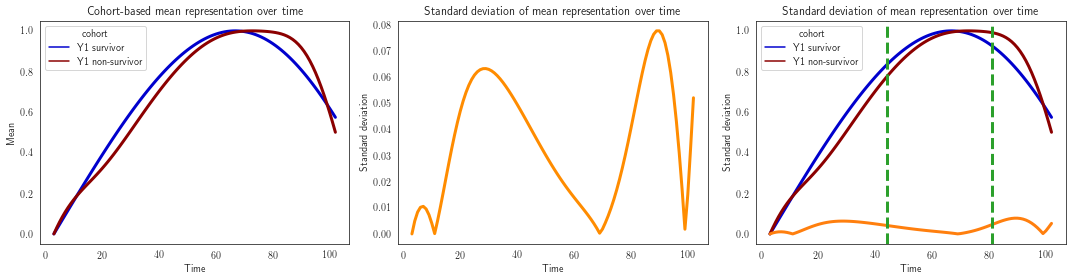

In [626]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Analyses the variability of representations (either summary statistic
# curves or persistence images) *across* cohorts for the data set.

# This is a tensor of shape (n, m, f) or (n, m), where n represents
# the number of subjects, m the number of time steps, and f the
# number of features. In case summary statistics are being used, this
# tensor will only be 2D because there is only a single feature.
Z = np.array(images0)
df_groups = pd.read_csv('participant_groups.csv')
df_groups.label = df_groups.label + 1
cohorts = df_groups['cluster'].values

assert len(cohorts) == Z.shape[0]

# Will become the cohort-based data frame
df = []

for cohort in sorted(set(cohorts)):
    cohort_mean = np.mean(Z[cohorts == cohort], axis=0)

    # Have another axis to summarise, so let's do this in order to
    # obtain a scalar representation.
    #
    # Notice that we are calculating the *maximum* here; this is in
    # line with the 'infinity norm' calculation.
    if len(cohort_mean.shape) == 2:
        cohort_mean = np.max(cohort_mean, axis=-1)

    # Make sure that the cohort mean representation *over time* is
    # normalised between [0, 1] as we do not want to penalise if a
    # certain cohort has higher activation values on average.
    cohort_mean = (cohort_mean - cohort_mean.min())
    cohort_mean /= (cohort_mean.max() - cohort_mean.min())

    for t, value in enumerate(cohort_mean):
        # TODO: make the time shift configurable
        #if args.drop:
        t += 3

        df.append(
            {
                'mean': value,
                'cohort': round(cohort),
                'time': t
            }
        )

#plt.figure(figsize=(6, 3))
df = pd.DataFrame(df)
df['cohort'] = df['cohort'].replace({0: 'Y1 survivor', 1: 'Y1 non-survivor'})

# Create a color map for the two cohorts
colors = {'Y1 survivor': "mediumblue", 'Y1 non-survivor': 'darkred'}
#df.pivot(index='time', columns='cohort', values='mean').plot()

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Plot the cohort-based data frame on the first subplot
#df.pivot(index='time', columns='cohort', values='mean').plot(ax=ax1, linewidth=3, hue='cohort', palette=colors)
sns.lineplot(data=df, x='time', y='mean', ax=ax1, linewidth=3, hue='cohort', palette=colors)

# Set the axis labels and title for the first subplot
ax1.set_xlabel('Time')
ax1.set_ylabel('Mean')
ax1.set_title('Cohort-based mean representation over time')

# Plot the standard deviation of the mean representation on the second subplot
df.groupby('time')['mean'].agg(np.std).plot(ax=ax2, linewidth=3, c='darkorange')

# Set the axis labels and title for the second subplot
ax2.set_xlabel('Time')
ax2.set_ylabel('Standard deviation')
ax2.set_title('Standard deviation of mean representation over time')

# Plot both data frame on the third subplot
#df.pivot(index='time', columns='cohort', values='mean').plot(ax=ax1, linewidth=3, hue='cohort', palette=colors)
sns.lineplot(data=df, x='time', y='mean', linewidth=3, hue='cohort', palette=colors)

# Set the axis labels and title for the first subplot
ax3.set_xlabel('Time')
ax3.set_ylabel('Mean')
ax3.set_title('Cohort-based mean representation over time')

# Plot the standard deviation of the mean representation on the second subplot
df.groupby('time')['mean'].agg(np.std).plot(ax=ax3, linewidth=3)

# Set the axis labels and title for the second subplot
ax3.set_xlabel('Time')
ax3.set_ylabel('Standard deviation')
ax3.set_title('Standard deviation of mean representation over time')

print(
    df.groupby('time')['mean']
        .agg(np.std)
        .reset_index()
        .to_csv(index=False, index_label='time')
)

df_annot = pd.read_excel('annotations.xlsx')

# Define a list of salience values to plot
top_effect_features = ['insuffisance rénale aiguë', 'dialyse en réanimation', 'Nb Jours Ventilation mécanique', 'étiologie BPCO', 'Analgésie péridurale ']

colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, salience_value in enumerate(top_effect_features):
    salience_values = df_annot[salience_value].values
    salience_values = np.nan_to_num(salience_values)
    indices, = np.nonzero(salience_values >= 102)

    for index in indices:
        plt.axvline(index, ls='dashed', c='C'+str(i), linewidth=i+1)
        
# Save the figure as a PDF file
fig.savefig('cohorts_variability_by_top5_effects.pdf', dpi=300, bbox_inches='tight')

# Show the figure
plt.tight_layout()
plt.show()

In [574]:
df_annot['étiologie BPCO']

0      0
1      1
2      0
3      0
4      0
      ..
247    0
248    1
249    0
250    1
251    1
Name: étiologie BPCO, Length: 252, dtype: int64

In [105]:
type(y)

list

In [270]:
plot_point_cloud(P[209])

In [271]:
#Next we convert each diagram into a 3-dimensional vector using persistent entropy and plot the resulting feature matrix:
from gtda.diagrams import PersistenceEntropy
persistence_entropy = PersistenceEntropy(normalize=True)

# Calculate topological feature matrix
X = persistence_entropy.fit_transform(persistence_diagrams)

# Visualise feature matrix
fig_entropy = plot_point_cloud(X)

# Save it in high quality resolution
pio.write_image(fig_entropy, 'persistence_entropy.pdf', format='pdf', scale=3)

In [272]:
X.shape

(252, 3)

In [273]:
# Training results
from sklearn.ensemble import RandomForestClassifier
labels = np.zeros(252)
labels[189:252] = 1

rf = RandomForestClassifier(oob_score=True, random_state=42)
rf.fit(X, labels)
rf.oob_score_

0.7619047619047619

In [274]:
# Validation results
from sklearn.model_selection import train_test_split
X_train, X_valid, labels_train, labels_valid = train_test_split(X, labels, random_state=89)
rf = RandomForestClassifier(oob_score=True, random_state=42)
rf.fit(X_train, labels_train)
#rf.oob_score_
rf.score(X_valid, labels_valid)

0.7777777777777778

In [275]:
from gtda.diagrams import NumberOfPoints
# Reshape single diagram to (n_samples, n_features, 3) format
diagram = persistence_diagrams[0][None, :, :]
# Get number of points for (H0, H1, H2)
NumberOfPoints().fit_transform(diagram)

array([[24,  1,  0]])

In [276]:
#A more sophisticated feature is to calculate a vector of amplitudes for each persistence diagram.
from gtda.diagrams import Amplitude

Amplitude(metric='wasserstein').fit_transform(persistence_diagrams)

array([[1.71435423e+00, 3.06499302e-01, 0.00000000e+00],
       [1.37031552e+00, 0.00000000e+00, 0.00000000e+00],
       [1.48384550e+00, 2.68785059e-01, 0.00000000e+00],
       [1.41941068e+00, 1.89519465e-01, 0.00000000e+00],
       [1.29373322e+00, 1.43446852e-01, 0.00000000e+00],
       [1.15434528e+00, 4.26971986e-02, 0.00000000e+00],
       [1.99438351e+00, 0.00000000e+00, 0.00000000e+00],
       [1.02539941e+00, 1.71124935e-04, 0.00000000e+00],
       [1.49550994e+00, 4.39651102e-02, 0.00000000e+00],
       [1.58119234e+00, 1.50581028e-01, 0.00000000e+00],
       [1.07910222e+00, 2.43479013e-03, 0.00000000e+00],
       [1.16347131e+00, 3.72314155e-02, 0.00000000e+00],
       [1.87132076e+00, 0.00000000e+00, 0.00000000e+00],
       [1.29444571e+00, 2.13980734e-01, 0.00000000e+00],
       [1.69286095e+00, 1.33486271e-01, 0.00000000e+00],
       [1.73489230e+00, 8.75994450e-02, 0.00000000e+00],
       [1.40779552e+00, 8.40807557e-02, 0.00000000e+00],
       [1.09523279e+00, 9.24094

In [277]:
Amplitude(metric='persistence_image').fit_transform(persistence_diagrams[197][None, :, :])

array([[30.82165011,  0.28636081,  0.        ]])

In [278]:
persistence_diagrams.shape

(252, 31, 3)

In [421]:
#So now that we know how to generate new topological features, let’s combine them using scikit-learn’s utility function for feature unions:

from sklearn.pipeline import make_union

# Select a variety of metrics to calculate amplitudes
metrics = [
    {"metric": metric}
    for metric in ["bottleneck", "wasserstein", "landscape","betti", "heat", "silhouette","persistence_image"]
]

# Concatenate to generate 3 + 3 + (4 x 3) = 18 topological features
feature_union = make_union(
    PersistenceEntropy(normalize=True),
    NumberOfPoints(n_jobs=-1),
    *[Amplitude(**metric, n_jobs=-1) for metric in metrics]
)

In [425]:
#The final step is to combine our feature extraction step with a classifier, fit the pipeline, and extract the OOB score:

from gtda.pipeline import Pipeline

pipe = Pipeline(
    [
        ("features", feature_union),
        ("rf", RandomForestClassifier(oob_score=True, random_state=42)),
        
    ]
)

X_train, X_valid, labels_train, labels_valid = train_test_split(persistence_diagrams, labels, random_state=89)

pipe.fit(X_train, labels_train)
pipe.score(X_valid, labels_valid)
#pipe["rf"].oob_score_


0.8095238095238095

In [427]:
#The final step is to combine our feature extraction step with a classifier, fit the pipeline, and extract the OOB score:
from sklearn.neural_network import MLPClassifier
from gtda.pipeline import Pipeline

pipe = Pipeline(
    [
        ("features", feature_union),
        ("mlp", MLPClassifier(alpha=1e-1, max_iter=1000, solver='lbfgs', hidden_layer_sizes=(5, 2), random_state=0)), # alpha = original alpha*np.sqrt(n_samples)
        
    ]
)

X_train, X_valid, labels_train, labels_valid = train_test_split(persistence_diagrams, labels, random_state=89)

pipe.fit(X_train, labels_train)

#Return the mean accuracy on the given test data and labels.
pipe.score(X_valid, labels_valid)

0.8888888888888888

(63,)
(63, 2)


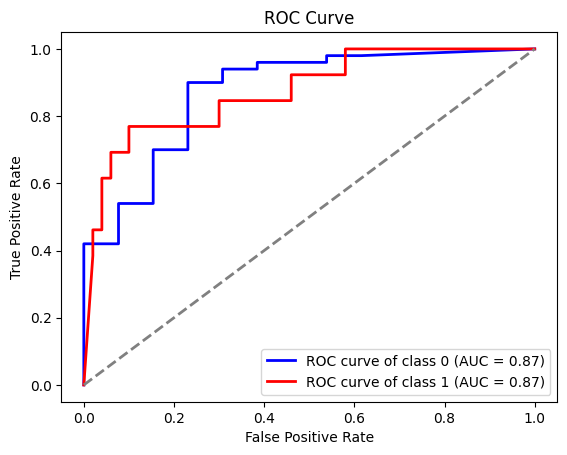

In [284]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for each class
probs = pipe.predict_proba(X_valid)

# Check the shape of labels_valid and probs
print(labels_valid.shape) # should be (n_samples,)
print(probs.shape) # should be (n_samples, n_classes)

# Get the fpr, tpr, and thresholds for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], thresholds = roc_curve(labels_valid, probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure()
colors = ['blue', 'red'] # Add more colors as needed for additional classes
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

# Plot the random chance line
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Set the axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [285]:
import plotly.graph_objs as go
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for each class
probs = pipe.predict_proba(X_valid)

# Get the fpr, tpr, and thresholds for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], thresholds = roc_curve(labels_valid, probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Create an interactive plot using plotly
fig = go.Figure()

# Add a trace for each class
for i in range(2):
    fig.add_trace(
        go.Scatter(
            x=fpr[i],
            y=tpr[i],
            mode='lines',
            name=f'Class {i} (AUC={roc_auc[i]:.2f})',
            line=dict(width=2)
        )
    )

# Add the random chance line
fig.add_trace(
    go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode='lines',
        name='Random Chance',
        line=dict(color='gray', width=2, dash='dash')
    )
)

# Customize the layout
fig.update_layout(
    title='ROC Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    xaxis=dict(range=[0, 1]),
    yaxis=dict(range=[0, 1])
)

# Show the plot
fig.show()


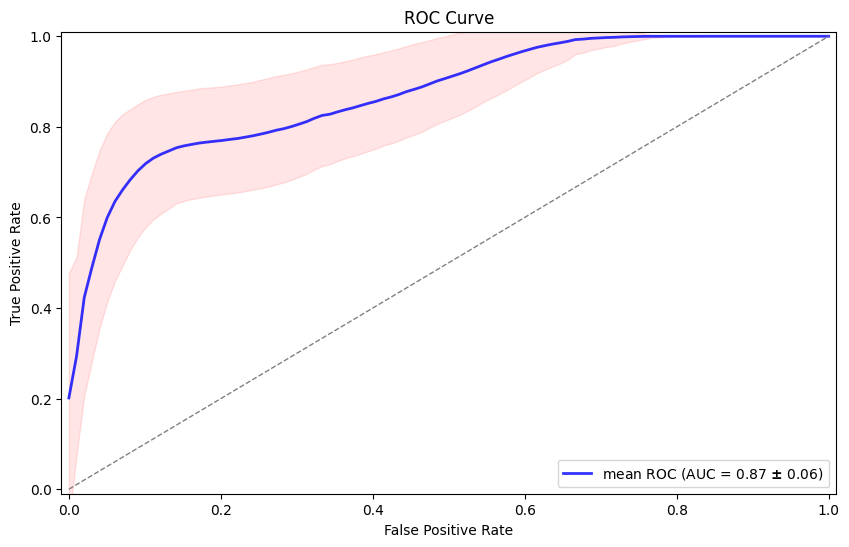

In [289]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt


def generate_bootstrap_indices(n_samples, n_bootstraps, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    indices = np.arange(n_samples)
    bootstrap_indices = np.zeros((n_bootstraps, n_samples), dtype=int)
    for i in range(n_bootstraps):
        bootstrap_indices[i, :] = np.random.choice(indices, n_samples)
    return bootstrap_indices


n_bootstraps = 2000
bootstrap_indices = generate_bootstrap_indices(len(labels_valid), n_bootstraps)

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
for i in range(n_bootstraps):
    fpr, tpr, _ = roc_curve(labels_valid[bootstrap_indices[i]], probs[bootstrap_indices[i]][:, 1], pos_label=1)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    aucs.append(auc(fpr, tpr))

mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.figure(figsize=(10, 6))
plt.plot(mean_fpr, mean_tpr, color='b', label=f'mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})', lw=2, alpha=.8)
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, alpha=.1, color='r')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


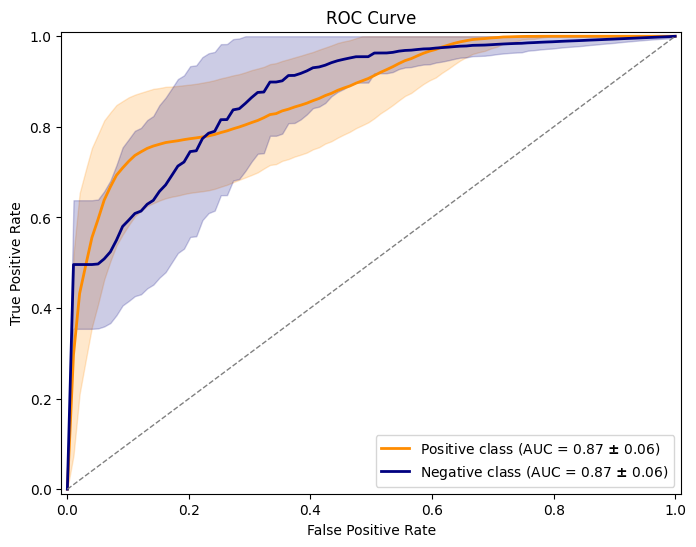

In [297]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample

def generate_bootstrap_indices(n_samples, n_bootstraps):
    bootstrap_indices = []
    for i in range(n_bootstraps):
        bootstrap_indices.append(resample(range(n_samples)))
    return bootstrap_indices

n_bootstraps = 2000
bootstrap_indices = generate_bootstrap_indices(len(labels_valid), n_bootstraps)

mean_fpr = np.linspace(0, 1, 100)

tprs_positive = []
aucs_positive = []
fprs_positive = []
tprs_negative = []
aucs_negative = []
fprs_negative = []

for i in range(n_bootstraps):
    fpr, tpr, _ = roc_curve(labels_valid[bootstrap_indices[i]], probs[bootstrap_indices[i]][:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs_positive.append(interp_tpr)
    aucs_positive.append(roc_auc)
    fprs_positive.append(fpr)
    
    fpr, tpr, _ = roc_curve(labels_valid[bootstrap_indices[i]], probs[bootstrap_indices[i]][:, 0], pos_label=0)
    roc_auc = auc(fpr, tpr)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs_negative.append(interp_tpr)
    aucs_negative.append(roc_auc)
    fprs_negative.append(fpr)

tprs_positive = np.array(tprs_positive)
aucs_positive = np.array(aucs_positive)
mean_tpr_positive = tprs_positive.mean(axis=0)
mean_tpr_positive[-1] = 1.0
std_tpr_positive = tprs_positive.std(axis=0)
std_tpr_positive_upper = np.minimum(mean_tpr_positive + std_tpr_positive, 1)
std_tpr_positive_lower = np.maximum(mean_tpr_positive - std_tpr_positive, 0)

tprs_negative = np.array(tprs_negative)
aucs_negative = np.array(aucs_negative)
mean_tpr_negative = tprs_negative.mean(axis=0)
mean_tpr_negative[-1] = 1.0
std_tpr_negative = tprs_negative.std(axis=0)
std_tpr_negative_upper = np.minimum(mean_tpr_negative + std_tpr_negative, 1)
std_tpr_negative_lower = np.maximum(mean_tpr_negative - std_tpr_negative, 0)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(mean_fpr, mean_tpr_positive, color='darkorange', lw=2, label='Positive class (AUC = %0.2f $\pm$ %0.2f)' % (aucs_positive.mean(), aucs_positive.std()))
ax.fill_between(mean_fpr, std_tpr_positive_lower, std_tpr_positive_upper, color='darkorange', alpha=.2)

ax.plot(mean_fpr, mean_tpr_negative, color='navy', lw=2, label='Negative class (AUC = %0.2f $\pm$ %0.2f)' % (aucs_negative.mean(), aucs_negative.std()))
ax.fill_between(mean_fpr, std_tpr_negative_lower, std_tpr_negative_upper, color='navy', alpha=.2)

ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


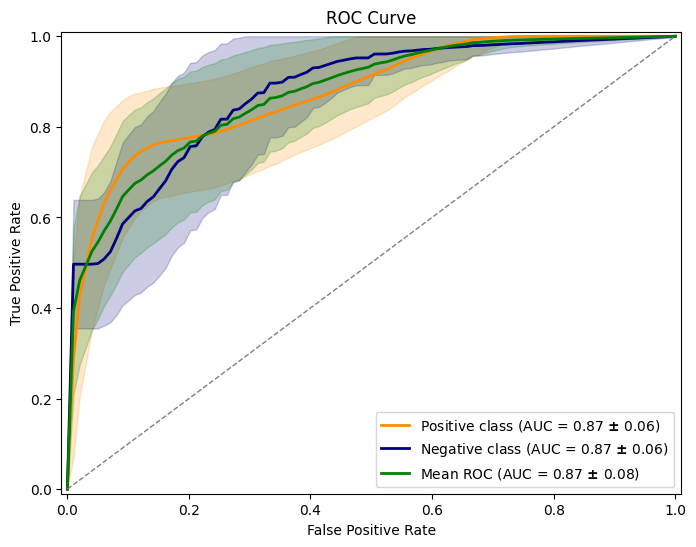

In [301]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample

def generate_bootstrap_indices(n_samples, n_bootstraps):
    bootstrap_indices = []
    for i in range(n_bootstraps):
        bootstrap_indices.append(resample(range(n_samples)))
    return bootstrap_indices

n_bootstraps = 2000
bootstrap_indices = generate_bootstrap_indices(len(labels_valid), n_bootstraps)

mean_fpr = np.linspace(0, 1, 100)

tprs_positive = []
aucs_positive = []
fprs_positive = []
tprs_negative = []
aucs_negative = []
fprs_negative = []

for i in range(n_bootstraps):
    fpr, tpr, _ = roc_curve(labels_valid[bootstrap_indices[i]], probs[bootstrap_indices[i]][:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs_positive.append(interp_tpr)
    aucs_positive.append(roc_auc)
    fprs_positive.append(fpr)
    
    fpr, tpr, _ = roc_curve(labels_valid[bootstrap_indices[i]], probs[bootstrap_indices[i]][:, 0], pos_label=0)
    roc_auc = auc(fpr, tpr)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs_negative.append(interp_tpr)
    aucs_negative.append(roc_auc)
    fprs_negative.append(fpr)

tprs_positive = np.array(tprs_positive)
aucs_positive = np.array(aucs_positive)
mean_tpr_positive = tprs_positive.mean(axis=0)
mean_tpr_positive[-1] = 1.0
std_tpr_positive = tprs_positive.std(axis=0)
std_tpr_positive_upper = np.minimum(mean_tpr_positive + std_tpr_positive, 1)
std_tpr_positive_lower = np.maximum(mean_tpr_positive - std_tpr_positive, 0)

tprs_negative = np.array(tprs_negative)
aucs_negative = np.array(aucs_negative)
mean_tpr_negative = tprs_negative.mean(axis=0)
mean_tpr_negative[-1] = 1.0
std_tpr_negative = tprs_negative.std(axis=0)
std_tpr_negative_upper = np.minimum(mean_tpr_negative + std_tpr_negative, 1)
std_tpr_negative_lower = np.maximum(mean_tpr_negative - std_tpr_negative, 0)

# Calculate mean ROC curve across both classes
mean_tpr = (mean_tpr_positive + mean_tpr_negative) / 2
mean_auc = (aucs_positive.mean() + aucs_negative.mean()) / 2
std_tpr = np.sqrt((std_tpr_positive ** 2 + std_tpr_negative ** 2) / 2)
std_tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
std_tpr_lower = np.maximum(mean_tpr - std_tpr, 0)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(mean_fpr, mean_tpr_positive, color='darkorange', lw=2, label='Positive class (AUC = %0.2f $\pm$ %0.2f)' % (aucs_positive.mean(), aucs_positive.std()))
ax.fill_between(mean_fpr, std_tpr_positive_lower, std_tpr_positive_upper, color='darkorange', alpha=.2)

ax.plot(mean_fpr, mean_tpr_negative, color='navy', lw=2, label='Negative class (AUC = %0.2f $\pm$ %0.2f)' % (aucs_negative.mean(), aucs_negative.std()))
ax.fill_between(mean_fpr, std_tpr_negative_lower, std_tpr_negative_upper, color='navy', alpha=.2)

ax.plot(mean_fpr, mean_tpr, color='green', lw=2, label='Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_tpr.mean()))
ax.fill_between(mean_fpr, std_tpr_lower, std_tpr_upper, color='green', alpha=.2)

ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Save the figure as a PDF file
fig.savefig('Roc_curve_classes_mean_smooth_MLP.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [303]:
from sklearn.metrics import confusion_matrix

# Get the predicted labels on validation data
predicted_labels = pipe.predict(X_valid)

# Calculate the confusion matrix
cm = confusion_matrix(labels_valid, predicted_labels)

# Calculate true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN)
TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]

# Calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)

print("Precision:", precision)
print("Recall:", recall)


Precision: 0.75
Recall: 0.6923076923076923


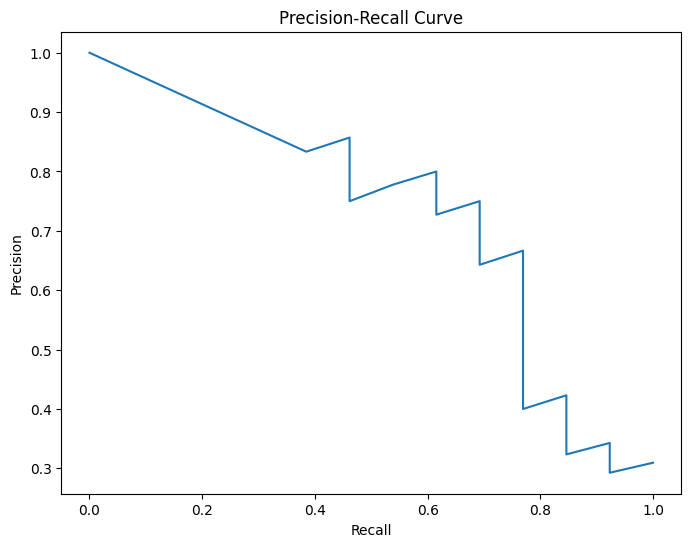

In [446]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# ...

# fit the pipeline to the training data
pipe.fit(X_train, labels_train)

# get the predicted probabilities for the validation data
y_pred_proba = pipe.predict_proba(X_valid)

# calculate precision and recall at different probability thresholds
precision, recall, thresholds = precision_recall_curve(labels_valid, y_pred_proba[:, 1])

fig, ax = plt.subplots(figsize=(8, 6))

# plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# Save the figure as a PDF file
fig.savefig('precision_recall_curve_MLP.pdf', dpi=300, bbox_inches='tight')


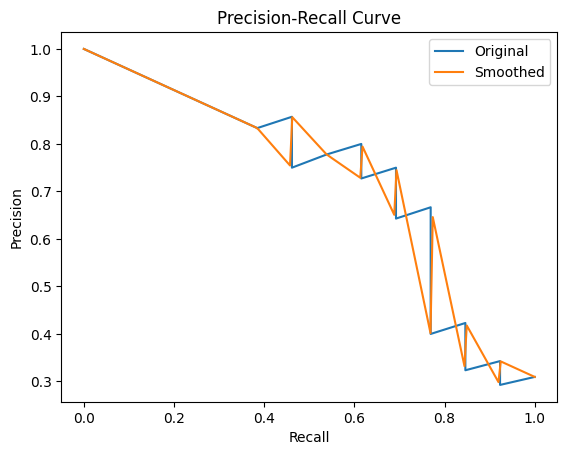

In [309]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# ...

# fit the pipeline to the training data
pipe.fit(X_train, labels_train)

# get the predicted probabilities for the validation data
y_pred_proba = pipe.predict_proba(X_valid)

# calculate precision and recall at different probability thresholds
precision, recall, thresholds = precision_recall_curve(labels_valid, y_pred_proba[:, 1])

# Compute smoothed curve
x_smooth = np.linspace(0, 1, 200)
interp_precision = interp1d(recall, precision)
y_smooth = interp_precision(x_smooth)

# Plot original and smoothed curves
plt.plot(recall, precision, label="Original")
plt.plot(x_smooth, y_smooth, label="Smoothed")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


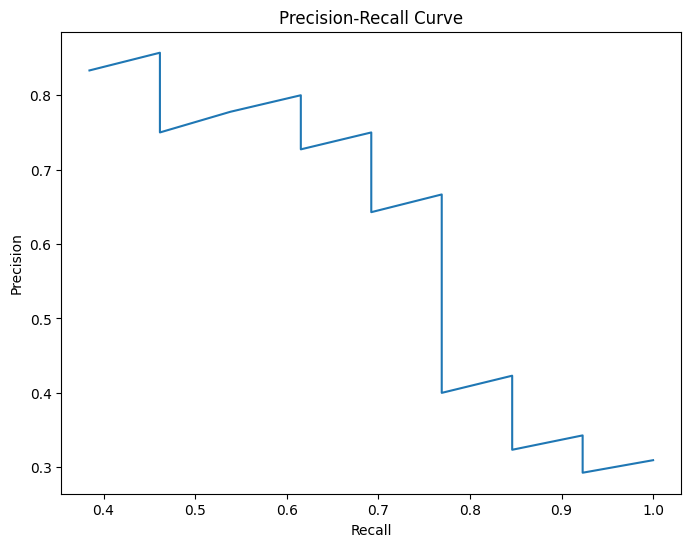

In [447]:
from sklearn.metrics import precision_recall_curve, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# ...
# fit the pipeline to the training data
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# ...

# fit the pipeline to the training data
pipe.fit(X_train, labels_train)

# get the predicted probabilities for the validation data
y_pred_proba = pipe.predict_proba(X_valid)

# calculate precision and recall at different probability thresholds
precision, recall, thresholds = precision_recall_curve(labels_valid, y_pred_proba[:, 1])

fig, ax = plt.subplots(figsize=(8, 6))

# plot the precision-recall curve
plt.plot(recall[:-1], precision[:-1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# Save the figure as a PDF file
fig.savefig('precision_recall_curve_zoom_in_MLP.pdf', dpi=300, bbox_inches='tight')

In [438]:
from sklearn.metrics import f1_score, precision_recall_curve
import matplotlib.pyplot as plt

def plot_evaluation_curves(model, X_valid, y_valid):
    # predict the labels for validation data
    y_pred = model.predict(X_valid)

    # calculate the F1 score
    f1 = f1_score(y_valid, y_pred, average='weighted')

    # calculate the precision-recall curve
    precision, recall, _ = precision_recall_curve(y_valid, y_pred)

    # plot the F1 and precision-recall curves
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # plot the F1 curve
    axs[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray')
    axs[0].set_xlim([-0.05, 1.05])
    axs[0].set_ylim([-0.05, 1.05])
    axs[0].set_xlabel('Recall', fontsize=14)
    axs[0].set_ylabel('Precision', fontsize=14)
    axs[0].set_title('Precision-Recall Curve\nF1 Score: {:.2f}'.format(f1), fontsize=16)
    axs[0].plot(recall, precision, lw=2)

    # plot the precision-recall curve
    axs[1].step(recall, precision, color='b', alpha=0.2, where='post')
    axs[1].fill_between(recall, precision, step='post', alpha=0.2, color='b')
    axs[1].set_xlabel('Recall', fontsize=14)
    axs[1].set_ylabel('Precision', fontsize=14)
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_title('Precision-Recall Curve\nF1 Score: {:.2f}'.format(f1), fontsize=16)
    
    # add gridlines to both plots
    axs[0].grid(alpha=0.2)
    axs[1].grid(alpha=0.2)
    
    # increase font size of tick labels
    axs[0].tick_params(labelsize=12)
    axs[1].tick_params(labelsize=12)
    
    # show the plot
    plt.tight_layout()
    plt.show()
    # Save the figure as a PDF file
    fig.savefig('precision_recall_F1_curve_MLP.pdf', dpi=300, bbox_inches='tight')


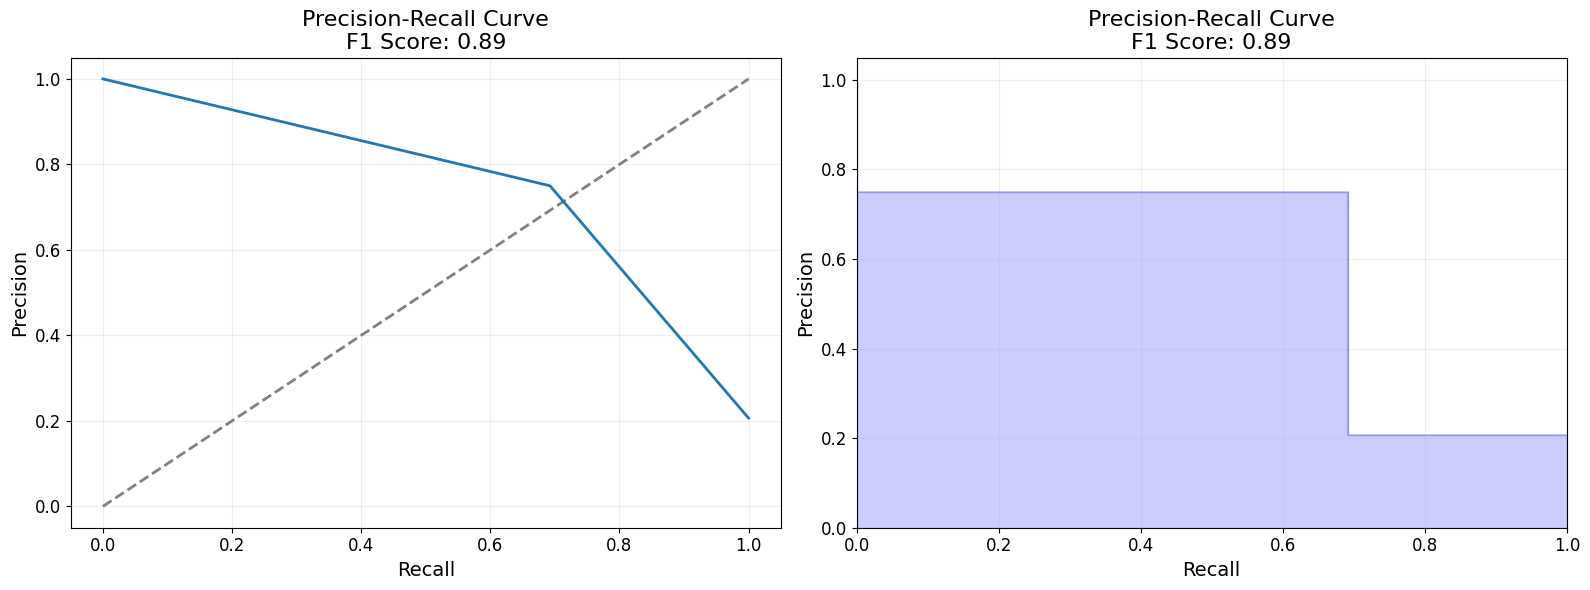

In [439]:
plot_evaluation_curves(pipe, X_valid, labels_valid)

This code defines a function called plot_evaluation_curves that takes in a trained model (model), validation data (X_valid and y_valid), and plots two evaluation curves: the precision-recall curve and F1 curve.

First, the function predicts the labels for the validation data using the model. Then it calculates the F1 score using the f1_score function from sklearn.metrics. The average parameter is set to weighted to take into account the imbalance of classes in the validation data.

Next, it calculates the precision-recall curve using the precision_recall_curve function from sklearn.metrics. The resulting precision and recall values are stored in the precision and recall variables, respectively.

Then, the function creates a plot with two subplots using plt.subplots. The first subplot displays the F1 curve, and the second subplot displays the precision-recall curve. Both subplots have the recall values on the x-axis and the precision values on the y-axis.

In the first subplot, a gray dashed line is plotted to represent the baseline. The set_xlim and set_ylim methods set the limits for the x and y axes, respectively. The set_xlabel, set_ylabel, and set_title methods set the labels and title for the plot. The actual F1 curve is plotted using the plot method.

In the second subplot, the step method is used to plot a step function with the precision values as the y-coordinates and the recall values as the x-coordinates. The fill_between method is used to shade the area under the curve. The rest of the methods used in the second subplot are similar to the ones used in the first subplot.

Finally, the function adds gridlines to both subplots, increases the font size of the tick labels, shows the plot, and saves it as a PDF file using the savefig method.

In [433]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Flatten each persistence diagram in X_train
X_train_flattened = np.array([np.ravel(dgm) for dgm in X_train])

# Perform RFE on the feature_union object
rfecv = RFECV(feature_union, step=1, cv=5, scoring='roc_auc')
rfecv.fit(X_train_flattened, labels_train)
selected_features = feature_union.get_feature_names()[rfecv.support_]

# Split data into training and testing sets
X_train_2, X_test, y_train, y_test = train_test_split(persistence_diagrams, labels, test_size=0.3, random_state=42)
#X_train_2 = X_train_2.reshape(X_train_2.shape[0], -1)
# Create empty list to store AUROC scores
aurocs = []

# Loop over different feature sets
for k in range(1, len(selected_features)+1):
    # Select top k features
    selected = selected_features[:k]
    # Fit pipeline with selected features and classifier
    pipe = Pipeline([
        ("features", feature_union),
        ("rfe", RFECV(feature_union, step=1, cv=5, scoring='roc_auc')),
        ("clf", MLPClassifier(alpha=1e-1, max_iter=1000, solver='lbfgs', hidden_layer_sizes=(5, 2), random_state=0))
    ])
    pipe.fit(X_train, y_train)
    # Calculate AUROC score on testing set
    auroc = roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1])
    aurocs.append(auroc)

# Plot mean AUROC scores and 95% confidence intervals
plt.errorbar(range(1, len(selected_features)+1), np.mean(aurocs, axis=0), yerr=1.96*np.std(aurocs, axis=0)/np.sqrt(len(aurocs)), fmt='o-', capsize=5)
plt.xlabel('Number of features')
plt.ylabel('AUROC')
plt.title('AUROC by number of features after RFE')
plt.show()


ValueError: Input should be a 3D ndarray, the shape is (151, 93).

In [435]:
len(labels_train)

189

# MLP visualisation with pydotplus and netron

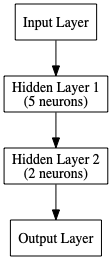

In [863]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
import pydotplus
from IPython.display import Image

# Generate a random binary classification dataset
X, y = make_classification(n_features=4, random_state=0)

# Create an MLPClassifier with a specific architecture
mlp = MLPClassifier(hidden_layer_sizes=(5, 2), activation='relu', solver='lbfgs', alpha=1e-1, max_iter=1000, random_state=0)

# Fit the MLPClassifier to the data
mlp.fit(X, y)

# Create the input and output layer nodes
input_layer_node = pydotplus.Node('Input Layer', shape='rectangle')
output_layer_node = pydotplus.Node('Output Layer', shape='rectangle')

# Create the hidden layer nodes
hidden_layers = []
for i, layer_size in enumerate(mlp.hidden_layer_sizes):
    hidden_layer = pydotplus.Node(f'Hidden Layer {i+1}\n({layer_size} neurons)', shape='rectangle')
    hidden_layers.append(hidden_layer)

# Connect the input layer to the first hidden layer
input_to_hidden = (input_layer_node.get_name(), hidden_layers[0].get_name())
# Connect the last hidden layer to the output layer
hidden_to_output = (hidden_layers[-1].get_name(), output_layer_node.get_name())

# Connect the hidden layers in sequence
hidden_edges = []
for i in range(len(hidden_layers) - 1):
    edge = (hidden_layers[i].get_name(), hidden_layers[i+1].get_name())
    hidden_edges.append(edge)

# Create the graph and add the nodes and edges
graph = pydotplus.graph_from_edges([input_to_hidden, hidden_to_output] + hidden_edges, directed=True)
graph.add_node(input_layer_node)
graph.add_node(output_layer_node)
for node in hidden_layers:
    graph.add_node(node)

# Generate and display the graph
Image(graph.create_png())


In [97]:
# netron
import keras
from keras.layers import Dense, Input
from keras.models import Model
import netron

# Define the model architecture
inputs = Input(shape=(784,))
x = Dense(64, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

# Save the model in Keras format
keras.models.save_model(model, 'model.h5')

# Launch Netron to visualize the model
netron.start('model.h5')


Serving 'model.h5' at http://localhost:8080


2023-03-22 14:44:57.704577: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


('localhost', 8080)

# variable contributions by shap values

In [100]:
X=df2_standard_scale.iloc[:,0:48]

In [98]:
from BorutaShap import BorutaShap

In [235]:
# no model selected default is Random Forest, if classification is False it is a Regression problem
Feature_Selector = BorutaShap(importance_measure='shap',
                              classification=True)

Feature_Selector.fit(X=X, y=y, n_trials=100, random_state=0)

  0%|          | 0/100 [00:00<?, ?it/s]

4 attributes confirmed important: ['Acute_Renal_Failure', 'Dialysis_in_ICU', 'ICU_stay_duration', '\\#Days_Mechanical_Ventilation']
41 attributes confirmed unimportant: ['Tracheotomy', 'Pneumonia_with_BLSE_and/or_abscess_in_ICU', 'Severe_bronchial_stenosis_in_past_year(stent_or_dilation)', 'Peroperative_Transfusion$>$2U', 'Pleurisy$<$1year', 'Perioperative_ECMO', 'ECMO_in_ICU', 'Max_Cold_Ischemia$>$6h', 'BMI(body_mass_index)', 'Age', '\\#Days_Mechanical_Ventilation$\\geq$3', 'Etiology_BPCO', '\\#Days_ECMO_in_ICU$\\geq$1', 'CMV_Mismatch', '\\#Days_Noradrenaline$\\geq$2', 'BMI$>$25', 'Etiology_Fibrosis', 'ICU_stay_duration$\\geq$15days', 'Age$\\geq$60', 'BMI$>$30', 'Ischemic_heart_disease', 'PAPM(mean_pulmonary_arterial_pressure)', 'Cellular_rejection_in_past_year', 'Humoral_rejection_in_past_year', 'Other_etiologies', 'Primary_Graft_Dysfunction_grade_3', 'Pre-operative_diabetes', 'Type_of_TP(0=single_lung,1=double_lung)', 'Bacteremia', 'Pneumonia(all_germs)', '\\#Days_Noradrenaline', 'S

In [236]:
# as 3 attributes are still undecided we have two choices either increase the n_trials or use the TentativeRoughFix()
# method which compares the median values of the max shadow feature and the undecided features.
Feature_Selector.TentativeRoughFix()

0 tentative features are now accepted: []
3 tentative features are now rejected: ['Sex(0=F,1=M)' '\\#Days_ECMO_in_ICU' 'IGS2_Day_0']


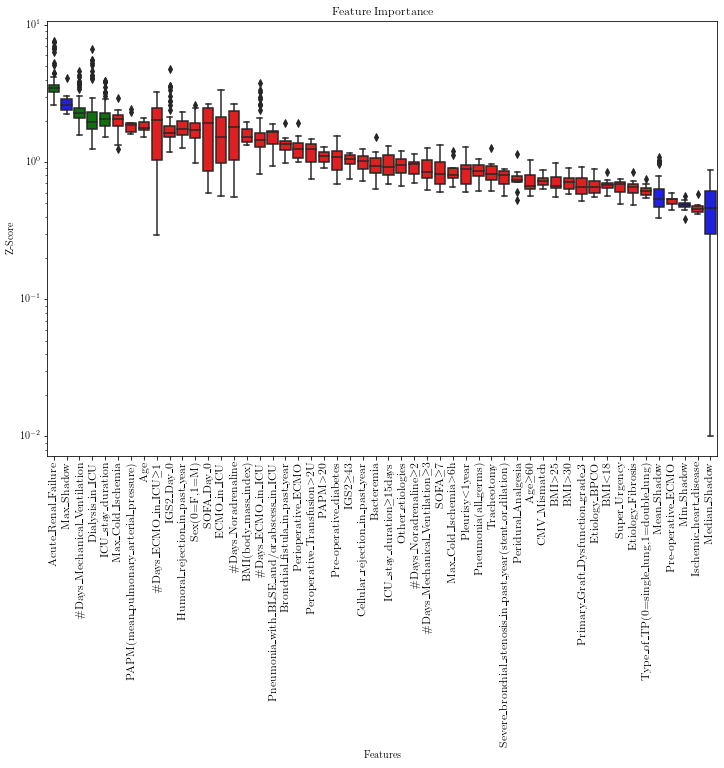

<Figure size 432x288 with 0 Axes>

In [237]:
# Returns Boxplot of features
Feature_Selector.plot(X_size=12, figsize=(12,8),
            y_scale='log', which_features='all')
plt.savefig('Y1risk_GP_BorutaS_RanFor.pdf', dpi=300, bbox_inches='tight')

In [377]:
# Sampling
Feature_Selector.fit(X=X, y=y, n_trials=100, random_state=0, sample=True)

  0%|          | 0/100 [00:00<?, ?it/s]

4 attributes confirmed important: ['#Days_Mechanical_Ventilation', 'Dialysis_in_ICU', 'Acute_Renal_Failure', 'ICU_stay_duration']
43 attributes confirmed unimportant: ['Severe_bronchial_stenosis_in_past_year(stent_or_dilation)', 'Pre-operative_ECMO', 'IGS2>=43', 'Age>=60', 'Super_Urgency', 'BMI>30', 'Pleurisy<1year', 'Peroperative_Transfusion>2U', 'Pneumonia(all_germs)', 'Peridural_Analgesia', 'SOFA_Day_0', 'CMV_Mismatch', '#Days_Mechanical_Ventilation>=3', 'PAPM(mean_pulmonary_arterial_pressure)', 'Cellular_rejection_in_past_year', 'ICU_stay_duration>=15days', 'Max_Cold_Ischemia>6h', 'ECMO_in_ICU', 'SOFA>=7', 'Type_of_TP(0=single_lung,1=double_lung)', 'Other_etiologies', 'Etiology_Fibrosis', 'Pneumonia_with_BLSE_and/or_abscess_in_ICU', '#Days_ECMO_in_ICU>=1', 'Bacteremia', '#Days_Noradrenaline', 'PAPM>20', 'BMI>25', 'BMI<18', 'Perioperative_ECMO', 'Humoral_rejection_in_past_year', 'Max_Cold_Ischemia', 'Tracheotomy', 'BMI(body_mass_index)', 'Sex(0=F,1=M)', 'Primary_Graft_Dysfunction_gr

In [378]:
# as 1 attribute is still undecided we have two choices either increase the n_trials or use the TentativeRoughFix()
# method which compares the median values of the max shadow feature and the undecided features.
Feature_Selector.TentativeRoughFix()

0 tentative features are now accepted: []
1 tentative features are now rejected: ['IGS2_Day_0']


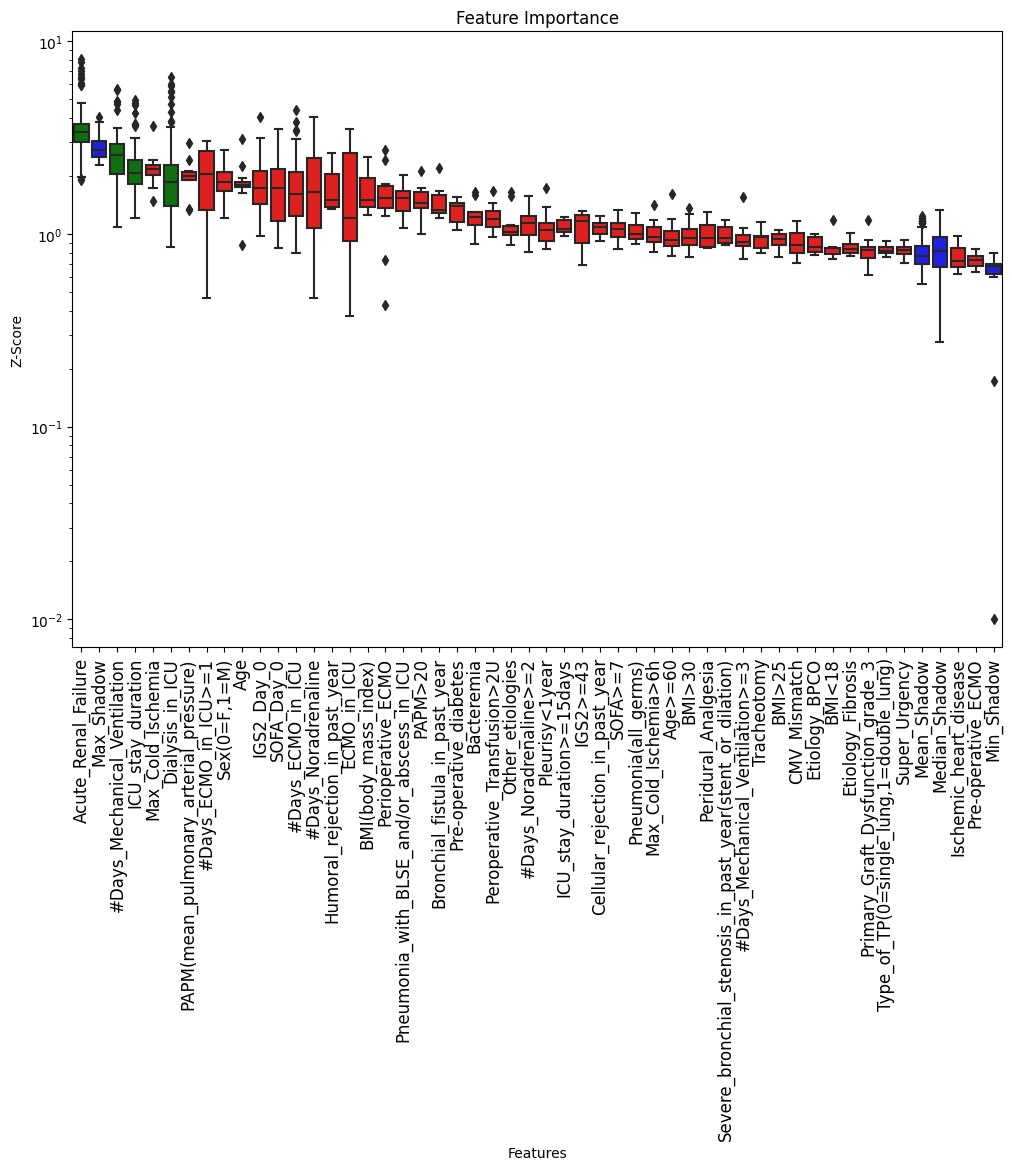

<Figure size 640x480 with 0 Axes>

In [381]:
# Returns Boxplot of features
Feature_Selector.plot(X_size=12, figsize=(12,8),
            y_scale='log', which_features='all')
plt.savefig('Y1risk_GP_BorutaS_RanFor_sampling.pdf', dpi=300, bbox_inches='tight')

# Alternative model -- Catboost

In [118]:
from catboost import CatBoostClassifier
model = CatBoostClassifier()

# no model selected default is Random Forest, if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=model,
                              importance_measure='shap',
                              classification=True)

Feature_Selector.fit(X=X, y=y, n_trials=300, random_state=0)

  0%|          | 0/300 [00:00<?, ?it/s]

6 attributes confirmed important: ['Sex(0=F,1=M)', 'PAPM$>$20', 'IGS2_Day_0', '\\#Days_Mechanical_Ventilation', 'Acute_Renal_Failure', 'Peroperative_Transfusion$>$2U']
42 attributes confirmed unimportant: ['BMI(body_mass_index)', 'Bronchial_fistula_in_past_year', 'Age$\\geq$60', 'Max_Cold_Ischemia', 'SOFA$\\geq$7', 'BMI$>$30', 'Etiology_Fibrosis', 'Severe_bronchial_stenosis_in_past_year(stent_or_dilation)', 'Humoral_rejection_in_past_year', 'Pneumonia(all_germs)', 'Pre-operative_diabetes', '\\#Days_Noradrenaline$\\geq$2', '\\#Days_ECMO_in_ICU$\\geq$1', 'ICU_stay_duration', '\\#Days_ECMO_in_ICU', 'Pleurisy$<$1year', 'ECMO_in_ICU', 'IGS2$\\geq$43', 'Pre-operative_ECMO', '\\#Days_Noradrenaline', 'Perioperative_ECMO', 'Type_of_TP(0=single_lung,1=double_lung)', 'Primary_Graft_Dysfunction_grade_3', 'Max_Cold_Ischemia$>$6h', 'PAPM(mean_pulmonary_arterial_pressure)', 'Peridural_Analgesia', 'Dialysis_in_ICU', 'Bacteremia', 'CMV_Mismatch', 'Cellular_rejection_in_past_year', 'Pneumonia_with_BLSE_

In [239]:
Feature_Selector.TentativeRoughFix()

0 tentative features are now accepted: []
0 tentative features are now rejected: []


<Figure size 432x288 with 0 Axes>

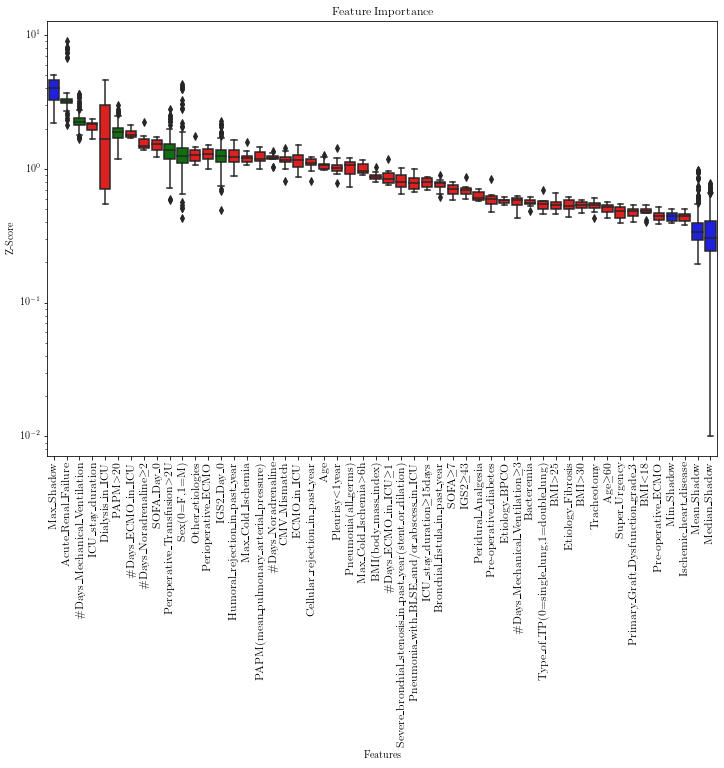

In [240]:
# Returns Boxplot of features
fig=plt.gcf()
Feature_Selector.plot(X_size=12, figsize=(12,8),
            y_scale='log', which_features='all')
fig.savefig('Y1risk_GP_BorutaS_CatBoost_300trials.pdf', dpi=300, bbox_inches='tight')

In [387]:
from lightgbm import LGBMClassifier
lgbm_model =LGBMClassifier(n_estimators=5000, min_child_samples=80, random_state=1307)
#lgbm_model.fit(X_train.values, y_train)

# no model selected default is Random Forest, if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=lgbm_model,
                              importance_measure='shap',
                              classification=True)
import re
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

Feature_Selector.fit(X=X, y=y, n_trials=100, random_state=0)

  0%|          | 0/100 [00:00<?, ?it/s]

2 attributes confirmed important: ['IGS2_Day_0', 'Days_Mechanical_Ventilation']
45 attributes confirmed unimportant: ['Dialysis_in_ICU', 'Pleurisy1year', 'Severe_bronchial_stenosis_in_past_yearstent_or_dilation', 'Super_Urgency', 'PAPM20', 'Type_of_TP0single_lung1double_lung', 'Days_ECMO_in_ICU1', 'Peridural_Analgesia', 'BMI18', 'CMV_Mismatch', 'SOFA_Day_0', 'Preoperative_diabetes', 'Sex0F1M', 'ICU_stay_duration15days', 'Days_Mechanical_Ventilation3', 'IGS243', 'BMI25', 'Cellular_rejection_in_past_year', 'ECMO_in_ICU', 'Pneumoniaall_germs', 'Other_etiologies', 'Etiology_Fibrosis', 'BMI30', 'Bacteremia', 'PAPMmean_pulmonary_arterial_pressure', 'Age60', 'BMIbody_mass_index', 'Peroperative_Transfusion2U', 'Preoperative_ECMO', 'Perioperative_ECMO', 'Humoral_rejection_in_past_year', 'Max_Cold_Ischemia', 'Days_Noradrenaline2', 'Tracheotomy', 'Acute_Renal_Failure', 'Primary_Graft_Dysfunction_grade_3', 'SOFA7', 'Days_ECMO_in_ICU', 'Bronchial_fistula_in_past_year', 'Ischemic_heart_disease', 'Da

1 tentative features are now accepted: ['Age']
0 tentative features are now rejected: []


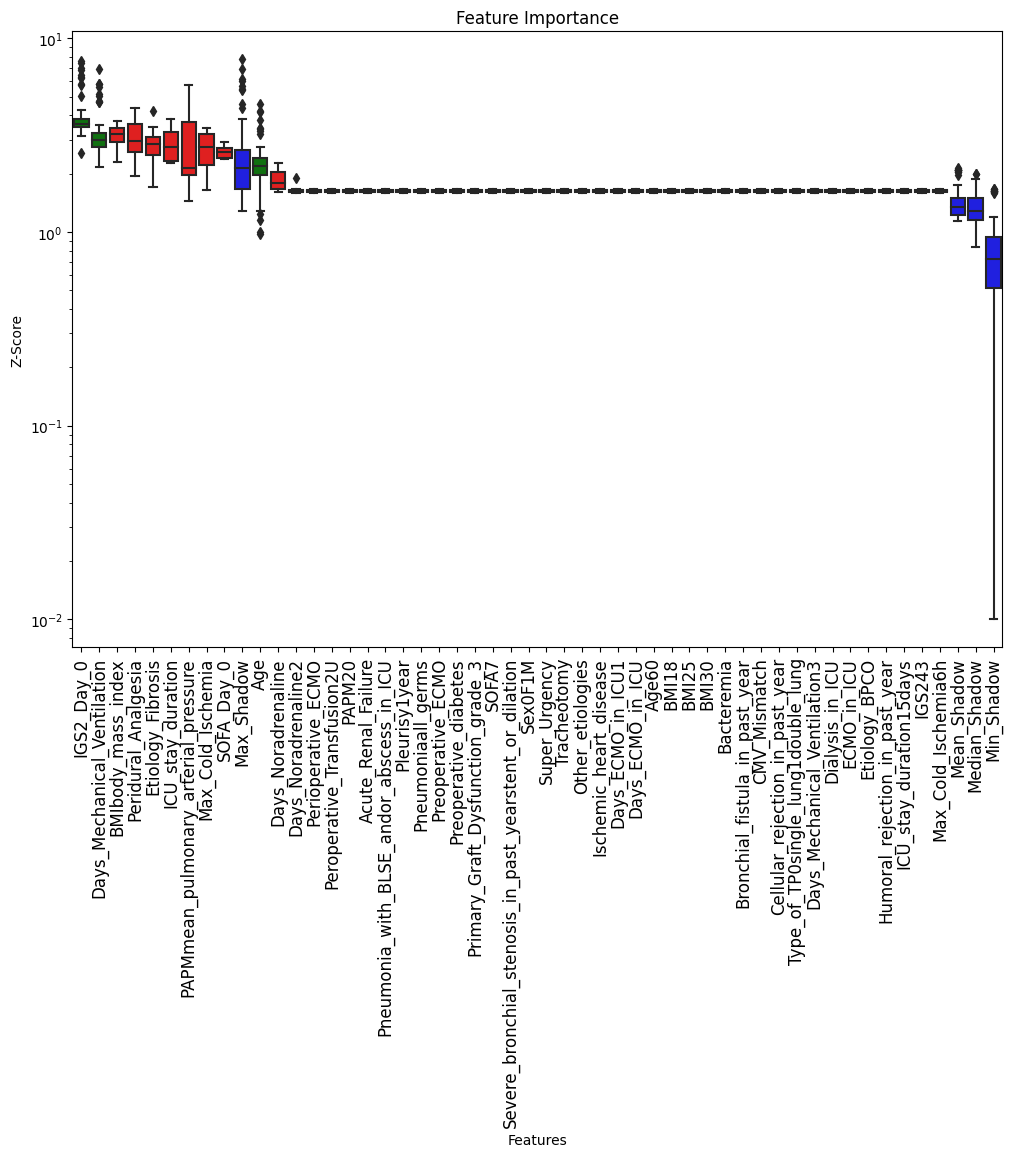

<Figure size 640x480 with 0 Axes>

In [390]:
Feature_Selector.TentativeRoughFix()
# Returns Boxplot of features
Feature_Selector.plot(X_size=12, figsize=(12,8),
            y_scale='log', which_features='all')
plt.savefig('Y1risk_GP_BorutaS_lightgbm_100trials.pdf', dpi=300, bbox_inches='tight')